In [21]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from elarb.policy import (
    optimal_policy, PolicyInput,
)
from elarb.models import (
    SolarPanel,
    Battery,
    GridConnection,
    Inverter,
)
from elarb import datasets

In [2]:
n_panels = widgets.IntSlider(value=1, min=0, max=200, description='Solar panels:', continuous_update=True)
n_inverters = widgets.IntSlider(value=1, min=0, max=10, description='Inverters:', continuous_update=True)
n_batteries = widgets.IntSlider(value=1, min=0, max=10, description='Batteries:', continuous_update=True)
stikledning_amp = widgets.IntSlider(value=63.0, min=0, max=100, description='Ampere:', continuous_update=True)
stikledning_volt = widgets.IntSlider(value=400, min=0, max=500, description='Volt:', continuous_update=True)

## Compute policy

In [49]:
df_nordpool = pd.read_csv('../data/example.csv', parse_dates=['HourUTC', 'HourDK', 'dt'])
ts0 = df_nordpool.HourDK.min()
ts1 = df_nordpool.HourDK.max()
df_nordpool.head(3)

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,dt,h
0,2022-07-29 10:00:00,2022-07-29 12:00:00,DK2,2936.149902,394.440002,2022-07-29,12
1,2022-07-29 11:00:00,2022-07-29 13:00:00,DK2,2727.800049,366.450012,2022-07-29,13
2,2022-07-29 12:00:00,2022-07-29 14:00:00,DK2,2717.300049,365.040009,2022-07-29,14


In [50]:
df_pv = pd.read_csv('../data/pvwatts.csv')
idx0 = df_pv[(df_pv.Month == ts0.month) & (df_pv.Day == ts0.day) & (df_pv.Hour == ts0.hour)].index[0]
idx1 = df_pv[(df_pv.Month == ts1.month) & (df_pv.Day == ts1.day) & (df_pv.Hour == ts1.hour)].index[0]+1
df_pv_win = df_pv[idx0:idx1].reset_index().copy()
df_pv_win.head(3)

,index,Month,Day,Hour,Beam Irradiance (W/m^2),Diffuse Irradiance (W/m^2),Ambient Temperature (C),Wind Speed (m/s),Plane of Array Irradiance (W/m^2),Cell Temperature (C),DC Array Output (W),AC System Output (W)
0,5028,7,29,12,6,387,19.7,5.1,364.2,27,335.9,322.7
1,5029,7,29,13,4,325,19.0,4.8,299.5,25,278.3,266.7
2,5030,7,29,14,17,236,18.2,4.4,223.8,23,209.7,200.0


## Configure and optimise

In [51]:
BIGNUM = 100

In [52]:
display(n_panels)
display(n_inverters)
display(n_batteries)
display(stikledning_amp)
display(stikledning_volt)

IntSlider(value=1, description='Solar panels:', max=200)

IntSlider(value=1, description='Inverters:', max=10)

IntSlider(value=1, description='Batteries:', max=10)

IntSlider(value=63, description='Ampere:')

IntSlider(value=400, description='Volt:', max=500)

In [53]:
# solar panels: 470Wp JinKO TigerNeo N-Type 60HL4 BF, 1.57 kWh / time, costs 1565 DKK
panel_deprecation = 1565 / (24*365*30)
panel = SolarPanel(m2=0.75, depreciation_per_hour=panel_deprecation)
print(panel)

SolarPanel(m2=0.75, depreciation_per_hour=0.005955098934550989)


In [54]:
# DK grid
grid = GridConnection(throughput_kWh=stikledning_amp.value * stikledning_volt.value / 1000)
print(grid)

GridConnection(throughput_kWh=25.2)


In [55]:
# Deye SUN-12K-SG04LP3-EU
inverter = Inverter(depreciation_per_hour=0.0, throughput_kWh=15.6, conversion_loss_pct=0.03,)
print(inverter)

Inverter(depreciation_per_hour=0.0, throughput_kWh=15.6, conversion_loss_pct=0.03)


In [56]:
# battery: Powerwall LBATTS Powerwall, 8.8 kwh
# bat_cost_dkk = 21000; bat_cycles = 6000; bat_depreciation = np.round(bat_cost_dkk / (8.8*bat_cycles), 3)
battery = Battery(depreciation_per_kWh=0.398, throughput_kWh=3.3, capacity_kWh=8.8, conversion_loss_pct=0.03,)
print(battery)

Battery(depreciation_per_kWh=0.398, throughput_kWh=3.3, capacity_kWh=8.8, conversion_loss_pct=0.03)


In [57]:
n = len(df_nordpool)
spot_price=df_nordpool.SpotPriceDKK.values/1000
pv_kWh = df_pv_win['AC System Output (W)'].values / 1000

policy_input = PolicyInput(
    pv_kWh=pv_kWh,
    spot_price=spot_price,
    spot_demand_kWh=np.zeros(n) + BIGNUM,
    spot_supply_kWh=np.zeros(n) + BIGNUM,
    panel=panel,
    battery=battery,
    inverter=inverter,
    grid=grid,
    n_panels=n_panels.value,
    n_batteries=n_batteries.value,
    n_inverters=n_inverters.value,
    initial_soc=0.0
)
print('INPUT')
print(f'- {n_panels.value} x {panel}')
print(f'- {n_inverters.value} x {inverter}')
print(f'- {n_batteries.value} x {battery}')
print(f'- {grid}')

res = optimal_policy(policy_input)

print()
print('OUTPUT')
print('- Objective value:', np.round(res.value, 3))
print('- X1 contribution:', np.round(res.x1_contrib, 3))
print('- X2 contribution:', np.round(res.x2_contrib, 3))
print('- X3 contribution:', np.round(res.x3_contrib, 3))
print('- X4 contribution:', np.round(res.x4_contrib, 3))
print('- Panel deprecation:', np.round(res.panel_depreciation, 3))
print('- Inverter deprecation:', np.round(res.inverter_depreciation, 3))
print('- Battery deprecation:', np.round(res.battery_depreciation, 3))
print('- Battery soc:', res.battery_soc_kWh.round(3))

INPUT
- 1 x SolarPanel(m2=0.75, depreciation_per_hour=0.005955098934550989)
- 1 x Inverter(depreciation_per_hour=0.0, throughput_kWh=15.6, conversion_loss_pct=0.03)
- 1 x Battery(depreciation_per_kWh=0.398, throughput_kWh=3.3, capacity_kWh=8.8, conversion_loss_pct=0.03)
- GridConnection(throughput_kWh=25.2)

OUTPUT
- Objective value: 33.214
- X1 contribution: 6.91
- X2 contribution: 0.0
- X3 contribution: 90.777
- X4 contribution: -53.751
- Panel deprecation: 0.214
- Inverter deprecation: 0.0
- Battery deprecation: 10.507
- Battery soc: [0.    2.299 5.5   8.701 8.797 8.8   8.8   6.6   3.3   0.    0.    0.
 0.    0.    2.299 5.5   8.701 8.797 8.8   6.6   3.3   0.    0.    0.
 0.    2.299 5.5   8.701 8.797 8.8   8.8   8.8   8.8   5.5   2.2   0.   ]


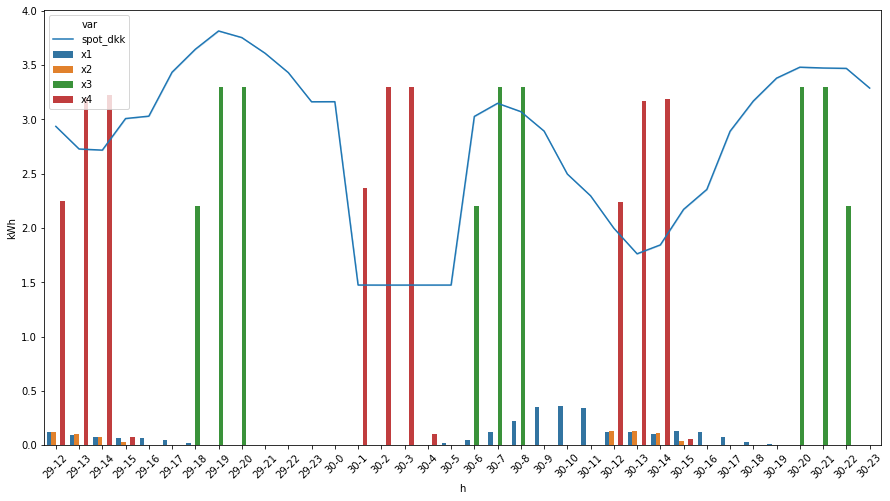

In [58]:
dts = [pd.to_datetime(d) for d in df_nordpool.HourDK]
h = [f'{d.day}-{d.hour}' for d in dts]
hs = np.tile(h, 4)
p = policy_input.spot_price
ps = np.tile(p, 4)
df_plot = pd.DataFrame({
    'h': hs,
    'spot_dkk': ps,
    'kWh': (
        res.x1.tolist()
        +res.x2.tolist()
        +res.x3.tolist()
        +res.x4.tolist()),
    'var': (
        ['x1']*n
        + ['x2']*n
        + ['x3']*n
        + ['x4']*n
    )
})
plt.figure(figsize=(15,8))
sns.lineplot(data=df_plot, x='h', y='spot_dkk', label='spot_dkk')
sns.barplot(data=df_plot, x='h', y='kWh', hue='var')
plt.xticks(rotation=45)
plt.show()

In [13]:
print(grid)
print(inverter)
print(battery)
print(policy_input.spot_price.round(2))
print(policy_input.spot_supply_kWh.round(2))
print(res.x4[:5].round(3).sum())

GridConnection(throughput_kWh=25.2)
Inverter(depreciation_per_hour=0.0, throughput_kWh=15.6, conversion_loss_pct=0.03)
Battery(depreciation_per_kWh=0.398, throughput_kWh=3.3, capacity_kWh=8.8, conversion_loss_pct=0.03)
[0.45 0.37 0.41 0.38 0.98 1.36 1.48 1.92 1.08 0.71 0.69 0.46 0.52 0.4
 0.07 0.07 0.07 0.08 0.95 1.69 1.98 1.62 1.23 1.18 0.99 0.97 0.98 1.04
 1.18 1.57 1.84 2.06 1.33 1.17 1.16 0.9 ]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]
8.558


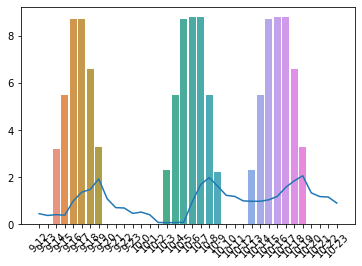

In [14]:
sns.barplot(x=h, y=res.battery_soc_kWh)
sns.lineplot(x=h, y=policy_input.spot_price)
plt.xticks(rotation=45)
plt.show()

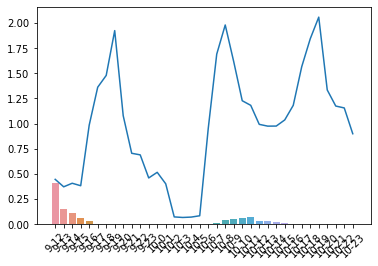

In [15]:
sns.barplot(x=h, y=res.x1)
sns.lineplot(x=h, y=policy_input.spot_price)
plt.xticks(rotation=45)
plt.show()

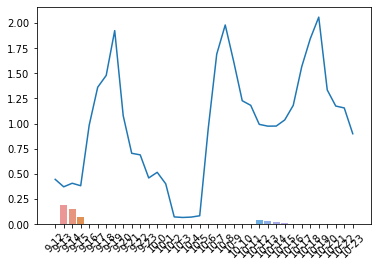

In [16]:
sns.barplot(x=h, y=res.x2)
sns.lineplot(x=h, y=policy_input.spot_price)
plt.xticks(rotation=45)
plt.show()

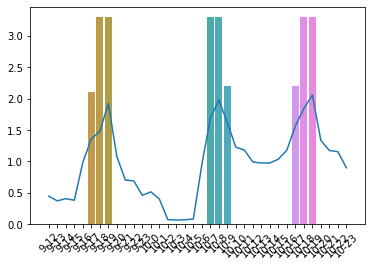

In [17]:
sns.barplot(x=h, y=res.x3)
sns.lineplot(x=h, y=policy_input.spot_price)
plt.xticks(rotation=45)
plt.show()

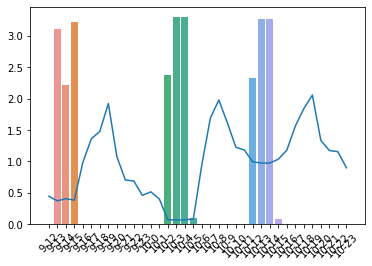

In [18]:
sns.barplot(x=h, y=res.x4)
sns.lineplot(x=h, y=policy_input.spot_price)
plt.xticks(rotation=45)
plt.show()

In [19]:
res.x4.round()

array([0., 3., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 3.,
       0., 0., 0., 0., 0., 0., 0., 2., 3., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [20]:
policy_input.spot_price.round(2)

array([0.45, 0.37, 0.41, 0.38, 0.98, 1.36, 1.48, 1.92, 1.08, 0.71, 0.69,
       0.46, 0.52, 0.4 , 0.07, 0.07, 0.07, 0.08, 0.95, 1.69, 1.98, 1.62,
       1.23, 1.18, 0.99, 0.97, 0.98, 1.04, 1.18, 1.57, 1.84, 2.06, 1.33,
       1.17, 1.16, 0.9 ])